In [48]:
%matplotlib inline
import future
import pylab as plt
import numpy as np
from bornagain import target
from scipy.spatial import distance
from bornagain.simulate import refdata

In [49]:
from loki.utils.postproc_helper import is_outlier

def single_atom_dens(atomic_num, grid_size=3, grid_spacing=0.05,
                    filter_atomic_core=True, filter_thresh=50, 
                    filter_sig=5):
    """
    atomic_num, atomic number of element 
    grid_size, size of cubic density grid in Angstrom
    grid_spacing, spacing of cubic grid in Angstrom
    filter_atomic_core, whether to filter the faulty density at atomic core
    """
    #print atomic_num
    Ngrid_pt = int( float(grid_size)/grid_spacing)

    vals = np.arange( -Ngrid_pt/2, Ngrid_pt/2)  * grid_spacing #, grid_spacing)
    
    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.sqrt( x**2 + y**2 + z**2 )
    R1 = R.ravel()

    rho = np.zeros( R1.shape).astype(np.float32)
    
    # this bit makes the form factor
    cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
    xo = 4.0 * (np.pi ** 2) * np.power( R1 , 2)
    for i in range(4):    
        rho += cromermann[i] * np.exp(-xo/cromermann[i+4])\
            / np.power(cromermann[i+4], 0.5 )
    
    rho *=  2 * np.sqrt(2) * np.pi

    if filter_atomic_core:
        dm = rho[ rho > 0].mean()
        s = rho [ rho > 0].std()

        idx = np.where( rho > dm+filter_sig*s)[0]
        vals = rho[ idx]
        bad = is_outlier( vals, filter_thresh)
        fillvalue = vals[~bad].max()
        bad_idx3 = idx[bad]
        rho[ bad_idx3] = fillvalue
        print ("Atom %d, replacing %d densities"%(atomic_num, sum(bad)))

    rho = rho.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt))
    
    return rho


In [50]:
# make a plot of the atomic densities to test them
grid_param = {'grid_spacing':0.3,'grid_size':6, 
                'filter_thresh':1000, 
              'filter_sig':0, 'filter_atomic_core':True}

In [51]:
# I will load the ubiquitin trajectory
import mdtraj

# loads in nanometers... o_O

#traj = mdtraj.load_dcd("ubq_ws_eq.dcd", top="ubq_ws.pdb")
traj = mdtraj.load_pdb("ubq_wb.pdb")
atoms = list(traj.topology.atoms)
atomic_nums = np.array( [ a.element.atomic_number for a in atoms] )


In [52]:
atom_vecs = traj.xyz[0]
print atom_vecs.shape

(77008, 3)


In [53]:
protein_idx = traj.top.select("is_protein")
water_idx = traj.top.select("is_water")
print("%d protein atoms"% protein_idx.shape[0])
print("%d water atoms"% water_idx.shape[0])


1231 protein atoms
75777 water atoms


In [54]:
# lets load a starting structure

# for now we only analyze one frame

protein_atom_vecs = traj.xyz[0, protein_idx]*10
protein_atom_vecs -= protein_atom_vecs.mean(0)
protein_atomic_nums = atomic_nums[protein_idx]


water_atom_vecs = traj.xyz[0,water_idx]*10
water_atom_vecs -= water_atom_vecs.mean(0)
water_atomic_nums = atomic_nums[water_idx]

print("These are the unique atoms, we load density for each:")
unique_atoms = np.unique( list(protein_atomic_nums)+ list(water_atomic_nums) )
unique_atom_dens = {n:single_atom_dens(n, grid_size=4, 
                        grid_spacing=0.2, filter_thresh=1000, 
                        filter_atomic_core=True, filter_sig=0) 
                for n in unique_atoms}

These are the unique atoms, we load density for each:
Atom 1, replacing 0 densities
Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 16, replacing 0 densities


In [55]:
protein_size = distance.pdist( protein_atom_vecs ).max()
print ("Protein is %.4f Angstrom across"% protein_size)
res = grid_param['grid_spacing']
grid_size = int( protein_size*1.5)
print grid_size
Npt = int(float(grid_size)/res)
vals = np.arange( -Npt/2,Npt/2)*res
n = unique_atom_dens[ unique_atom_dens.keys()[0]].shape[0]
print len(atom_vecs)

Protein is 44.2596 Angstrom across
66
77008


In [56]:
# map the molecule to the grid
import sys
protein_dens = np.zeros( (Npt,Npt,Npt), dtype=np.float32)
for atom_i,(a,Z) in enumerate(zip( protein_atom_vecs, protein_atomic_nums)):
    sys.stdout.flush()
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)
    pts = tuple( [ np.arange( x-n/2, x+n/2).astype(np.int32) for x in grid_pt])
    x,y,z = np.meshgrid( *pts)
    coors =  (x.ravel(), y.ravel(), z.ravel())

    protein_dens[coors] += unique_atom_dens[Z].ravel()
    nn = len( protein_atomic_nums) - atom_i
    print "\r atoms left: %4d"%(nn-1),
    

 atoms left:    0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

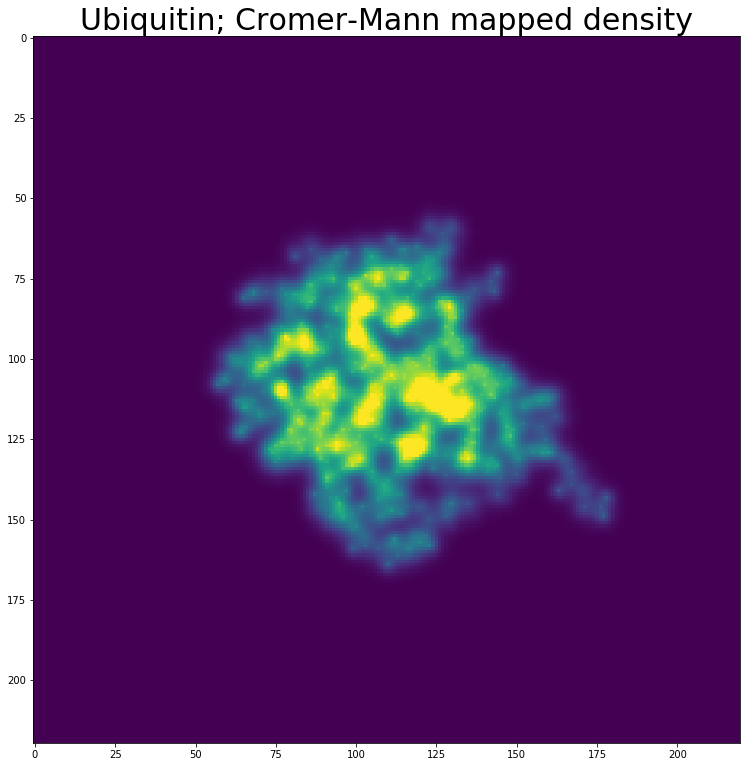

In [57]:
plt.figure(figsize=(13,13))
_=plt.title("Ubiquitin; Cromer-Mann mapped density", fontsize=30)
_=plt.imshow( protein_dens.mean(0), vmax=2)


In [93]:
# map the water to grid
water_dens = np.zeros( (Npt,Npt,Npt), dtype=np.float32)
for atom_i,(a,Z) in enumerate( zip( water_atom_vecs, water_atomic_nums)):
    sys.stdout.flush()
    
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)

    #checks if the waters are out of bounds (the protein are always in bounds by definition)
    #if np.any( grid_pt < 0):
    #    continue
    #if np.any(grid_pt >= Npt):
    #   continue
    
    pts = tuple( [ np.arange(x-n/2, x+n/2).astype(np.int32) for x in grid_pt])
    x,y,z = np.meshgrid( *pts)
    coors =  (x.ravel(), y.ravel(), z.ravel())

    coors2 = np.zeros( (coors[0].shape[0], 3))
    coors2[:,0] = coors[0]
    coors2[:,1] = coors[1]
    coors2[:,2] = coors[2]
    
    good1 = np.all( coors2 >=0, axis=1 )
    good2 = np.all( coors2 < Npt, axis=1)
    good = np.logical_and( good1, good2)
    #print sum(good) , len(good)
    if not np.any( good):
        continue
    #break
    cx,cy,cz = coors2[good].T.astype(int)
    coors3 = (cx,cy,cz)
    #print coors
    #print coors3
    #break
    water_dens[coors3] += (unique_atom_dens[Z].ravel()[good])
    #nn = len( water_atomic_nums) - atom_i
    print "\r atoms left: %4d"%(atom_i),
    

 atoms left: 14729                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

 atoms left: 30441                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

 atoms left: 47897                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

 atoms left: 69290                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

 atoms left: 75773                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [98]:
from scipy.interpolate import RegularGridInterpolator

#dens_points = map( np.ravel, np.indices( water_dens.shape))
dens_points = (vals,vals,vals)
water_regI = RegularGridInterpolator( dens_points, water_dens )
protein_regI = RegularGridInterpolator(dens_points, protein_dens)
whole_regI = RegularGridInterpolator(dens_points, water_dens+protein_dens)


Text(0.5,1,'Protein + water')

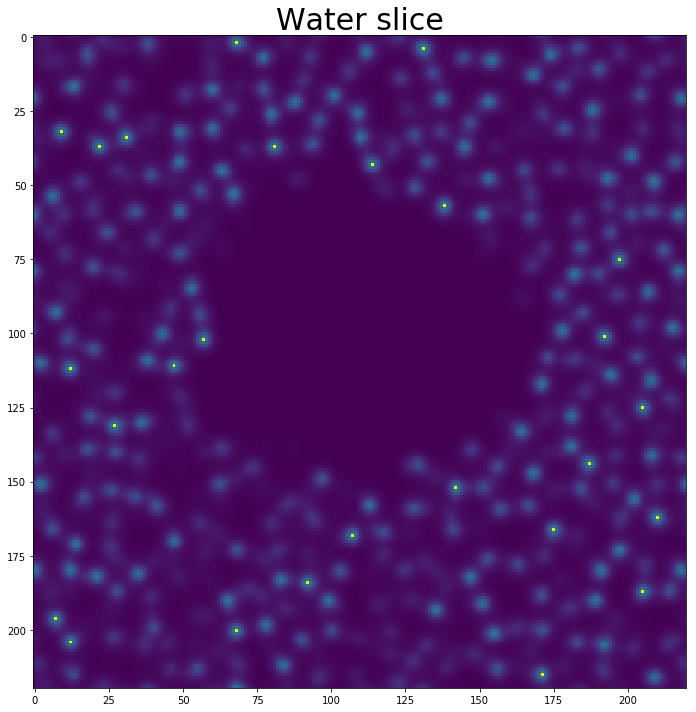

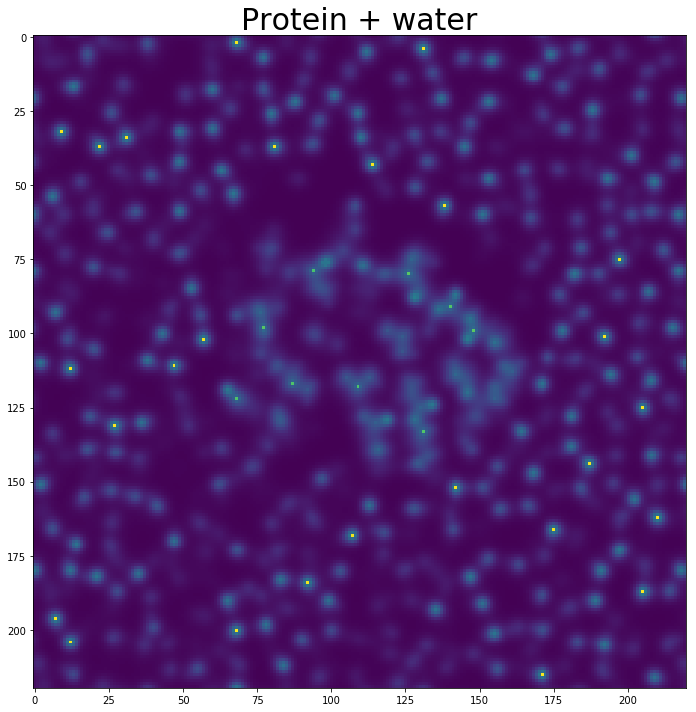

In [99]:
# view slices through the system
imgY,imgX = np.meshgrid(vals, vals)
interp_pts = np.array( zip(np.zeros(imgY.size), imgY.ravel(), imgX.ravel() ) )
plt.figure(figsize=(12,12))
water_img = water_regI(interp_pts)
plt.imshow( water_img.reshape( imgY.shape))
plt.title("Water slice", fontsize=30)

plt.figure(figsize=(12,12))
plt.imshow( whole_regI(interp_pts).reshape(imgY.shape))
plt.title("Protein + water", fontsize=30)

In [166]:
from scipy.fftpack import fftn, fftshift, fftfreq
Nfft = water_dens.shape[0]
diffrac_water_prot = np.abs(fftshift(fftn(water_dens+protein_dens, shape=[Nfft,Nfft,Nfft])))**2

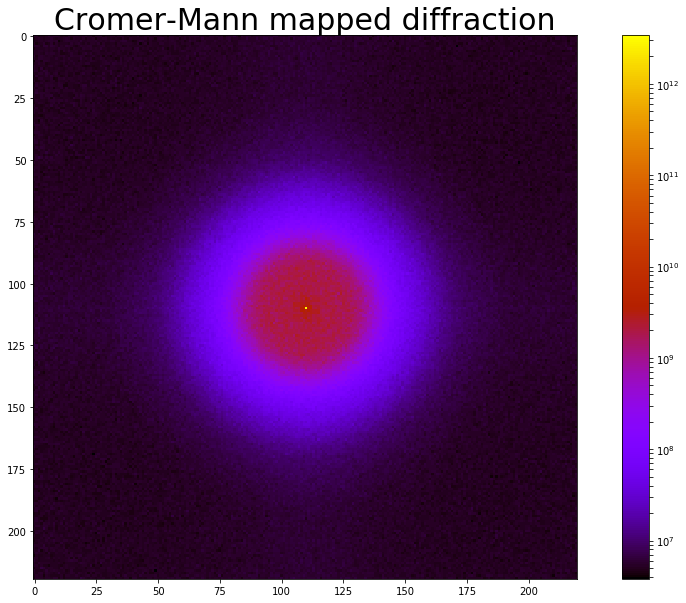

In [167]:
plt.figure(figsize=(16,10))
plt.title("Cromer-Mann mapped diffraction", fontsize=30)
_=plt.imshow( diffrac_water_prot.mean(0), norm=plt.mpl.colors.LogNorm(), cmap='gnuplot')
plt.colorbar()

In [168]:
from scipy.fftpack import fftn, fftshift, fftfreq
Nfft = Npt #water_dens.shape[0]
diffrac_protein_only = np.abs(fftshift(fftn(protein_dens, shape=[Nfft,Nfft,Nfft])))**2

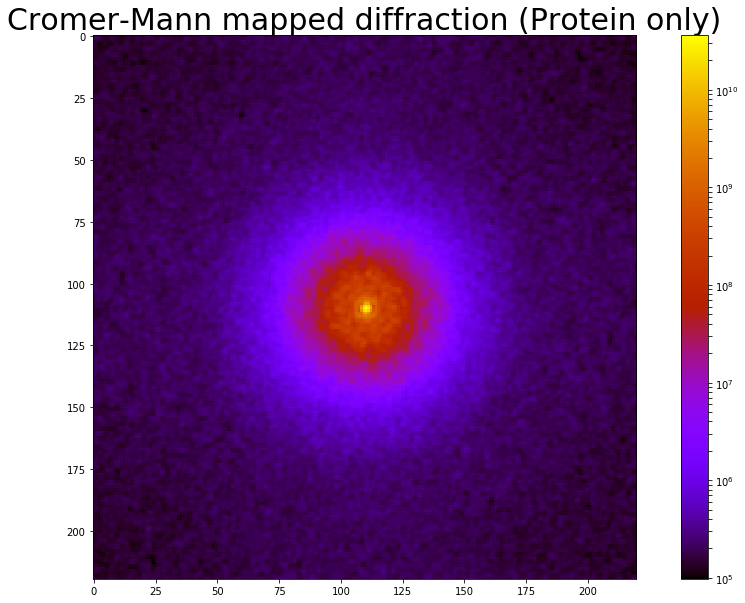

In [169]:
plt.figure(figsize=(16,10))
plt.title("Cromer-Mann mapped mean diffraction (Protein only)", fontsize=30)
_=plt.imshow( diffrac_protein_only.mean(0), norm=plt.mpl.colors.LogNorm(), cmap='gnuplot')
_=plt.colorbar()

In [178]:
qmags = 2*np.pi*fftshift( fftfreq(Nfft, grid_param['grid_spacing']) )
qmin, qmax = qmags.min(), qmags.max()
print qmin, qmax

-10.471975511965978 10.376775734584468


In [185]:
from scipy.interpolate import RegularGridInterpolator as RGI
Interp_water_prot = RGI([qmags]*3, diffrac_water_prot, bounds_error=False, fill_value=0)
Interp_protein_only = RGI([qmags]*3, diffrac_protein_only, bounds_error=False, fill_value=0)
from bornagain import SimplePAD
pad = SimplePAD( pixsize=0.00008, detdist=0.05, wavelen=1., n_pixels=1024)
q_pixels = pad.Q_vectors

In [189]:
img_water_prot = Interp_water_prot( q_pixels).reshape( pad.img_sh)
img_protein_only = Interp_protein_only( q_pixels).reshape( pad.img_sh)

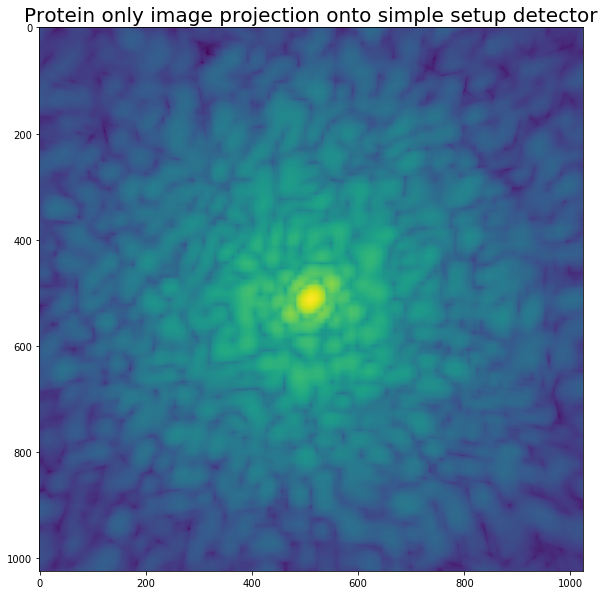

In [190]:
# plot the interpolation on the detector
plt.figure(1, figsize=(16,10))
plt.imshow( img_protein_only, norm=plt.mpl.colors.LogNorm() )
_=plt.title("Protein only image projection onto simple setup detector", fontsize=20)



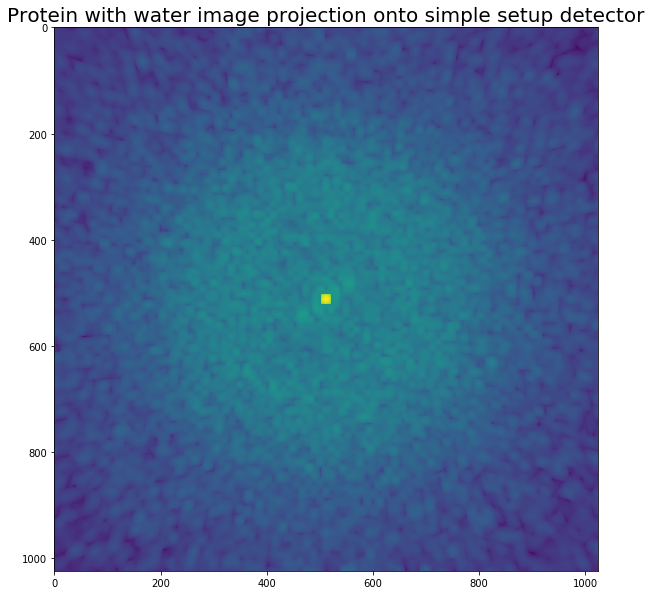

In [192]:
# plot the interpolation on the detector
plt.figure(1, figsize=(16,10))
plt.imshow( img_water_prot, norm=plt.mpl.colors.LogNorm() )
_=plt.title("Protein with water image projection onto simple setup detector", fontsize=20)

